# Import Libraries

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import string
import re
import nltk
from nltk.corpus import stopwords

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [19]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
df.shape

(50000, 2)

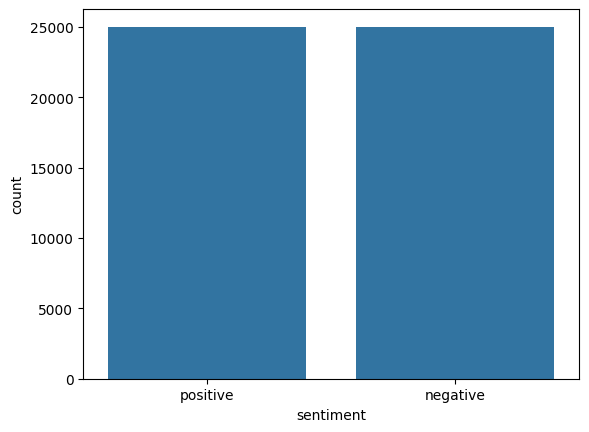

In [21]:
sns.countplot(x='sentiment',data=df)
plt.show()

In [22]:
def score(text):
    if text=='positive':
        return 1
    else:
        return 0

In [23]:
df['score'] = df['sentiment'].apply(score)

In [24]:
df

,review,sentiment,score
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


# Data Cleaning

In [25]:
df = df.drop('sentiment',axis=1)

In [26]:
df.isnull().sum()

review    0
score     0
dtype: int64

In [28]:
a = df.shape[0]
df.drop_duplicates(inplace=True)
b = df.shape[0]
print(f"No of rows removed : {a-b}")

No of rows removed : 418


In [29]:
df.shape

(49582, 2)

# Data Pre-processing

In [35]:
total_stopwords = set(stopwords.words('english'))
negative_stopwords = set(word for word  in total_stopwords if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stopwords

final_stopwords.add("one")
print(final_stopwords)

{"it'll", "i'm", 'why', 'we', 'yourselves', 'before', 'has', "it's", "they're", 'over', "we'd", 'm', 'between', 'here', 'hers', 'should', 'all', 'against', 'shan', 'off', "you've", 'her', 'these', 'any', 'myself', 'a', 'ain', 'itself', 'themselves', 'and', 'd', 'there', 'been', 'to', "we'll", "you'd", 'being', 'be', 'are', 'again', 'had', 'when', 'but', 'ma', 'his', 'just', 'mustn', 'only', 'o', 'ours', 'will', 'where', 'don', 'didn', 'most', 'for', 'll', "they've", 'about', 'doing', 'him', 'himself', 'this', 'who', 'me', 'on', 'yours', 'some', 'in', 'the', "we've", 'too', "we're", 're', 'both', 'by', 'so', 'yourself', 'wouldn', 've', 'it', 'below', 'down', 'he', 'same', 'if', 'during', 'once', 'aren', 'couldn', 'or', 'how', 'own', 'my', "i'll", 'what', 'while', 'their', 'needn', 'shouldn', 'such', 'at', 'mightn', 'weren', 'then', 'more', "should've", 'hasn', 'up', 'few', 'isn', 'because', 'was', "you're", 'that', 'does', 'above', "that'll", 'she', 't', 'theirs', 'after', 'as', 'an', "

In [40]:
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace

    filtered =[ words for words in text.split() if words not in final_stopwords]

    return ' '.join(filtered)

In [43]:
print("Before Preprocessing :")
df['review'][0]

Before Preprocessing :


"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [44]:
print("After Preprocessing :")
clean_text(df['review'][0])

After Preprocessing :


'reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust not show faint hearted timid show pulls no punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy not high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannere

# Wordclouds

In [49]:
def generate_wordcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords,background_color ="white")
    wordcloud.generate(text)
    plt.figure(figsize=(12,7))
    plt.axis('off')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.show()

Word Cloud for Positive reviews

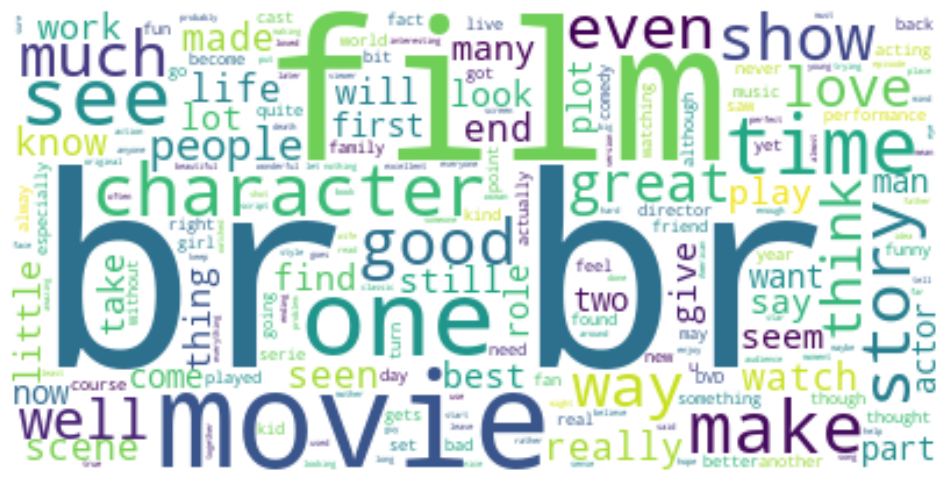

In [50]:
pos = df[df.score==1].review
text = " ".join(review for review in pos.astype(str))

generate_wordcloud(text)

Word Cloud for Negative reviews

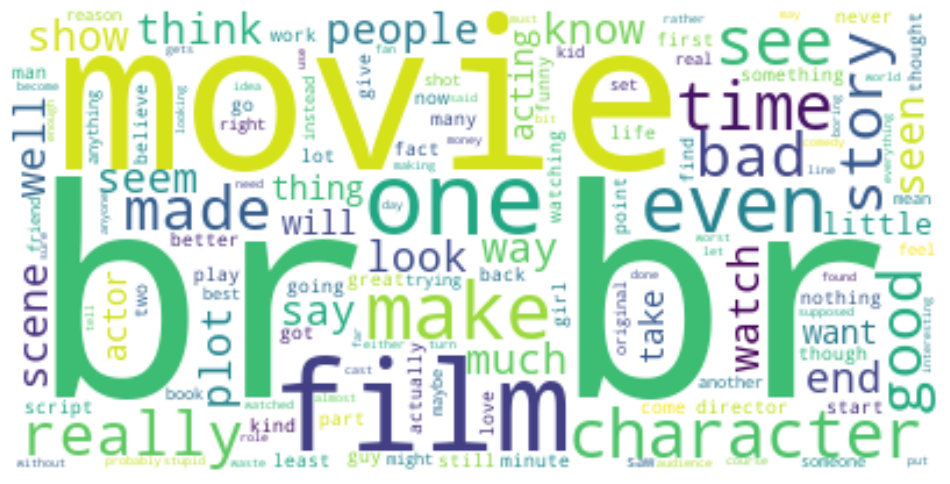

In [51]:
pos = df[df.score==0].review
text = " ".join(review for review in pos.astype(str))

generate_wordcloud(text)

train test split

In [58]:
X = df['review']
y = df['score']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

In [59]:
X_train.shape , X_test.shape

((39665,), (9917,))

# Vectorization

In [60]:
bow_vectorization = CountVectorizer(max_features=10000)
bow_vectorization.fit(X_train)
bow_X_train = bow_vectorization.transform(X_train)
bow_X_test = bow_vectorization.transform(X_test)

In [61]:
tfidf_vectorization = TfidfVectorizer(max_features=10000)
tfidf_vectorization.fit(X_train)
tfidf_X_train = tfidf_vectorization.transform(X_train)
tfidf_X_test = tfidf_vectorization.transform(X_test)

# Model Training

In [64]:
def train_and_eval(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred=y_pred,y_true=y_test)
    print(f"Accuracy score is {score}")
    print(f"Classification Report : {classification_report(y_pred=y_pred,y_true=y_test)}")

    cm = confusion_matrix(y_true=y_test,y_pred=y_pred,normalize='true')
    sns.heatmap(cm,annot=True,cmap='Blues')
    plt.show()

Naive Bayes

Accuracy score is 0.8384592114550772
Classification Report :               precision    recall  f1-score   support

           0       0.82      0.86      0.84      4940
           1       0.85      0.82      0.84      4977

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



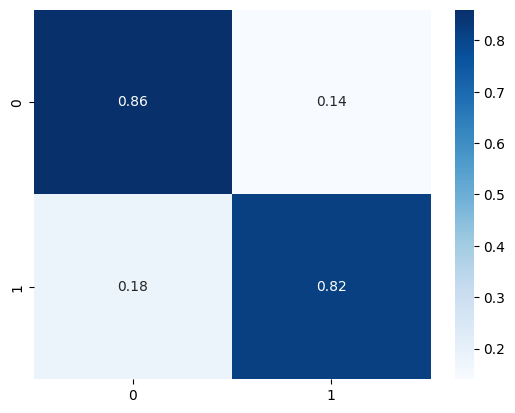

In [65]:
nb = MultinomialNB()
train_and_eval(nb,bow_X_train,y_train,bow_X_test,y_test)

 Logistic Regression

Accuracy score is 0.8935161843299385
Classification Report :               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.89      0.90      0.90      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



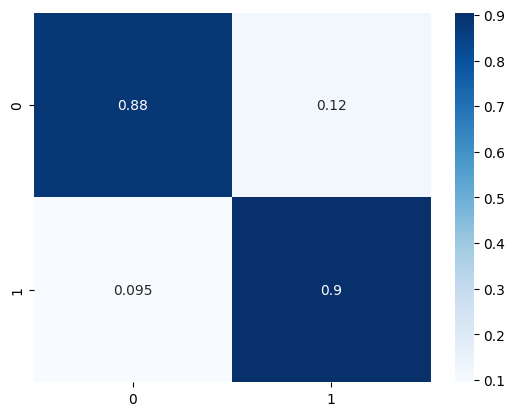

In [66]:
lr = LogisticRegression()
train_and_eval(lr,tfidf_X_train,y_train,tfidf_X_test,y_test)

Support Vector Machine

Accuracy score is 0.8978521730362005
Classification Report :               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4940
           1       0.89      0.91      0.90      4977

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



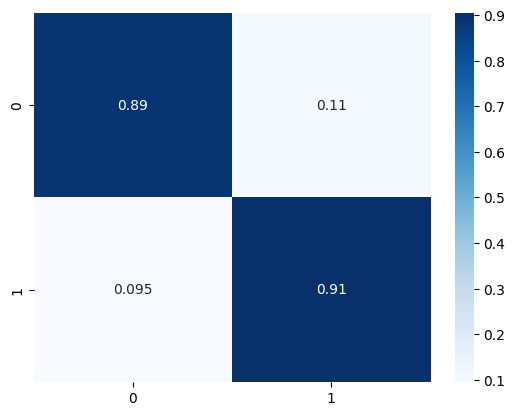

In [71]:
svc = SVC(kernel='linear')
train_and_eval(svc,tfidf_X_train,y_train,tfidf_X_test,y_test)

Decision Tree

Accuracy score is 0.7061611374407583
Classification Report :               precision    recall  f1-score   support

           0       0.71      0.70      0.70      4940
           1       0.71      0.71      0.71      4977

    accuracy                           0.71      9917
   macro avg       0.71      0.71      0.71      9917
weighted avg       0.71      0.71      0.71      9917



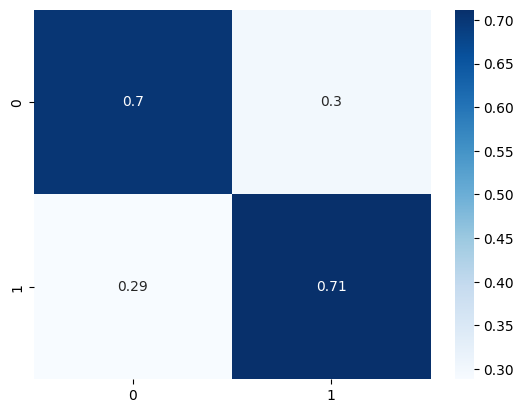

In [67]:
dc = DecisionTreeClassifier(criterion='entropy')
train_and_eval(dc,tfidf_X_train,y_train,tfidf_X_test,y_test)

Random Forest

Accuracy score is 0.8187960068569123
Classification Report :               precision    recall  f1-score   support

           0       0.87      0.75      0.80      4940
           1       0.78      0.89      0.83      4977

    accuracy                           0.82      9917
   macro avg       0.82      0.82      0.82      9917
weighted avg       0.82      0.82      0.82      9917



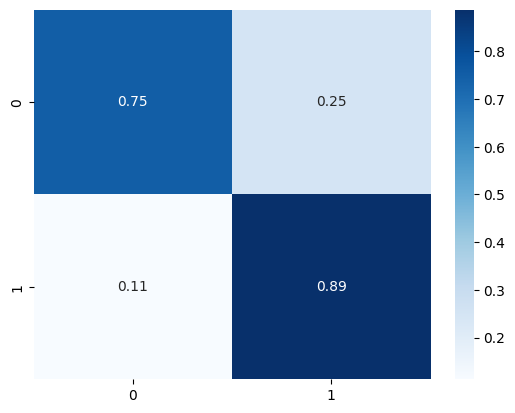

In [68]:
rf = RandomForestClassifier(n_estimators=1000,max_depth=6,criterion='gini')
train_and_eval(rf,tfidf_X_train,y_train,tfidf_X_test,y_test)

Xgboost

Accuracy score is 0.8355349400020168
Classification Report :               precision    recall  f1-score   support

           0       0.86      0.80      0.83      4940
           1       0.81      0.87      0.84      4977

    accuracy                           0.84      9917
   macro avg       0.84      0.84      0.84      9917
weighted avg       0.84      0.84      0.84      9917



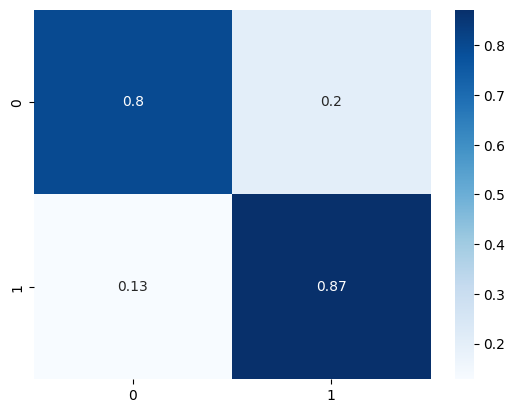

In [ ]:
xgb_model = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,eval_metric='logloss',random_state = 42)
train_and_eval(xgb_model, tfidf_X_train, y_train, tfidf_X_test, y_test)

# Predict

In [82]:
def predict(model,review):
    x = clean_text(review)
    x = tfidf_vectorization.transform([x])
    y = int(model.predict(x))
    return "Positive" if y==1 else "Negative"

SVM is the best model. We will use it for prediction

In [83]:
review = "This is a pretty good movie"
print(f"This is a {predict(svc,review)} review")

This is a Positive review


In [84]:
review = "What a terrible ending!"
print(f"This is a {predict(svc,review)} review")

This is a Negative review
